## Imports and dataset

In [861]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

### Dataset:
IRON WOLF. (2024). *Laptop Price - dataset* [Data set]. 
Kaggle. https://www.kaggle.com/datasets/ironwolf437/laptop-price-dataset?resource=download


In [862]:
dataset_cols = [
    "company",
    "product",
    "type",
    "inches",
    "screen_res",
    "cpu_company",
    "cpu_type",
    "cpu_speed",
    "ram",
    "memory",
    "gpu_company",
    "gpu_type",
    "weight",
    "price"
]
df = pd.read_csv("data/laptop_price - dataset.csv").drop(["OpSys"], axis=1)

In [863]:
df.columns = dataset_cols

In [864]:
df.head()

,company,product,type,inches,screen_res,cpu_company,cpu_type,cpu_speed,ram,memory,gpu_company,gpu_type,weight,price
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel,Core i5,2.3,8,128GB SSD,Intel,Iris Plus Graphics 640,1.37,1339.69
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel,Core i5,1.8,8,128GB Flash Storage,Intel,HD Graphics 6000,1.34,898.94
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel,Core i5 7200U,2.5,8,256GB SSD,Intel,HD Graphics 620,1.86,575.00
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel,Core i7,2.7,16,512GB SSD,AMD,Radeon Pro 455,1.83,2537.45
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel,Core i5,3.1,8,256GB SSD,Intel,Iris Plus Graphics 650,1.37,1803.60


In [865]:
# remove unpredictory data
df = df.drop(['product'], axis=1)

### Clean Data and preprocessing

#### Numerical and categoricals splitting values for screen_res

In [866]:
def clean_screen_resolution(df):
    
    res = df['screen_res'].str.extract(r'(\d+)\s*x\s*(\d+)', expand=True)

    # makes x and y res for numerical sake for better model
    df['x_res'] = res[0].astype(float)
    df['y_res'] = res[1].astype(float)

    # pixels per inch
    df['ppi'] = np.sqrt(df['x_res']**2 + df['y_res']**2) / df['inches']

    df['touchscreen'] = df['screen_res'].apply(
        lambda x: 1 if 'touch' in x.lower() else 0
    )

    
    def get_panel_type(text):
        if not isinstance(text, str):
            return 'ips'
        text = text.lower()
        if 'ips' in text:
            return 'ips'
        elif 'retina' in text:
            return 'retina'
        elif 'oled' in text:
            return 'oled'
        else:
            return 'ips'

    df['panel_type'] = df['screen_res'].apply(get_panel_type)

    df = df.drop(["screen_res"], axis=1)    

    return df


In [867]:

df = clean_screen_resolution(df)

In [868]:
df.sample(5)

,company,type,inches,cpu_company,cpu_type,cpu_speed,ram,memory,gpu_company,gpu_type,weight,price,x_res,y_res,ppi,touchscreen,panel_type
680,MSI,Gaming,15.6,Intel,Core i5 7300HQ,2.5,8,256GB SSD,Nvidia,GeForce GTX 1050,2.20,997.9,1920.0,1080.0,141.211998,0,ips
306,HP,2 in 1 Convertible,13.3,Intel,Core i7 7600U,2.8,16,256GB SSD,Intel,HD Graphics 620,1.28,1975.0,1920.0,1080.0,165.632118,1,ips
254,Acer,Notebook,17.3,Intel,Core i3 7130U,2.7,4,256GB SSD,Nvidia,GeForce MX130,3.00,702.0,1920.0,1080.0,127.335675,0,ips
1159,HP,2 in 1 Convertible,13.3,Intel,Core i7 6600U,2.6,8,512GB SSD,Intel,HD Graphics 520,1.48,2041.0,2560.0,1440.0,220.842824,1,ips
535,Dell,Notebook,15.6,Intel,Core i7 7600U,2.8,8,256GB SSD,Nvidia,GeForce 930MX,1.93,1369.0,1920.0,1080.0,141.211998,0,ips


#### Numerical values for memory

In [869]:

def clean_memory(df):
    df['memory'] = df['memory'].str.lower()

    # tb to gb
    df['memory'] = df['memory'].str.replace(
        r'(\d+(?:\.\d+)?)\s*tb',
        lambda m: f"{int(float(m.group(1)) * 1024)}gb",
        regex=True
    )

    df['ssd_gb'] = (
        df['memory']
        .str.findall(r'(\d+)\s*gb\s*(?:ssd|flash)')
        .apply(lambda x: int(x[0]) if x else 0)
    )

    # --- HDD ---
    df['hdd_gb'] = (
        df['memory']
        .str.findall(r'(\d+)\s*gb\s*hdd')
        .apply(lambda x: int(x[0]) if x else 0)
    )

    df = df.drop(['memory'], axis=1)
    return df



In [870]:
df = clean_memory(df)

In [871]:
df['total_memory'] = df['ssd_gb'] + df['hdd_gb']

In [872]:
df.sample(5)

,company,type,inches,cpu_company,cpu_type,cpu_speed,ram,gpu_company,gpu_type,weight,price,x_res,y_res,ppi,touchscreen,panel_type,ssd_gb,hdd_gb,total_memory
40,Asus,Notebook,15.6,Intel,Core i3 6006U,2.0,4,Intel,HD Graphics 620,2.00,389.0,1920.0,1080.0,141.211998,0,ips,0,1024,1024
472,Google,Ultrabook,12.3,Intel,Core i5 7Y57,1.2,8,Intel,HD Graphics 615,1.10,1275.0,2400.0,1600.0,234.507400,1,ips,128,0,128
248,HP,Notebook,13.3,Intel,Core i5 8250U,1.6,4,Intel,UHD Graphics 620,1.49,675.0,1920.0,1080.0,165.632118,0,ips,0,500,500
909,LG,Ultrabook,14.0,Intel,Core i7 7500U,2.7,8,Intel,HD Graphics 620,0.98,1899.0,1920.0,1080.0,157.350512,1,ips,512,0,512
1193,Apple,Ultrabook,12.0,Intel,Core M,1.1,8,Intel,HD Graphics 5300,0.92,1163.0,2304.0,1440.0,226.415547,0,ips,256,0,256


#### Clean cpu_type by only accepting series

In [873]:
df['cpu_type'] = df['cpu_type'].str.strip().str.title()
df['cpu_series'] = df['cpu_type'].str.extract(r'([A-Za-z0-9\-]+ ?[iI]?\d?)')
df = df.drop(['cpu_type'], axis=1)


#### clean gpu_type by only extracting numbers

In [874]:
df['gpu_model_num'] = df['gpu_type'].str.extract(r'(\d+)').astype(float)
# if nan
df['gpu_model_num'] = df['gpu_model_num'].fillna(df['gpu_model_num'].median())

df = df.drop(['gpu_type'], axis=1)


#### Turns out gpu_model_num was causing data leakage by being so few, it was telling the data during training the prices indirectly. Drop this

In [875]:
df = df.drop(['gpu_model_num'], axis=1)

#### remove any low number of items that will hinder with model

In [876]:
for col in df.columns:
    print(f"\n{col} value counts:")
    print(df[col].value_counts())


company value counts:
company
Dell         291
Lenovo       289
HP           268
Asus         152
Acer         101
MSI           54
Toshiba       48
Apple         21
Samsung        9
Mediacom       7
Razer          7
Microsoft      6
Vero           4
Xiaomi         4
Chuwi          3
Fujitsu        3
Google         3
LG             3
Huawei         2
Name: count, dtype: int64

type value counts:
type
Notebook              707
Gaming                205
Ultrabook             194
2 in 1 Convertible    117
Workstation            29
Netbook                23
Name: count, dtype: int64

inches value counts:
inches
15.6    647
14.0    193
17.3    164
13.3    160
12.5     39
11.6     31
13.5      6
12.0      6
13.9      6
12.3      5
10.1      4
15.4      4
15.0      4
13.0      2
18.4      1
17.0      1
14.1      1
11.3      1
Name: count, dtype: int64

cpu_company value counts:
cpu_company
Intel      1214
AMD          60
Samsung       1
Name: count, dtype: int64

cpu_speed value counts:
cpu_

#### Removes any item with less than 2 entries

In [877]:
df.columns

Index(['company', 'type', 'inches', 'cpu_company', 'cpu_speed', 'ram',
       'gpu_company', 'weight', 'price', 'x_res', 'y_res', 'ppi',
       'touchscreen', 'panel_type', 'ssd_gb', 'hdd_gb', 'total_memory',
       'cpu_series'],
      dtype='object')

In [878]:
for col in df.columns:
  counts = df[col].value_counts()
  rare_values = counts[counts <= 2].index
  df = df[~df[col].isin(rare_values)]

In [879]:
df.columns

Index(['company', 'type', 'inches', 'cpu_company', 'cpu_speed', 'ram',
       'gpu_company', 'weight', 'price', 'x_res', 'y_res', 'ppi',
       'touchscreen', 'panel_type', 'ssd_gb', 'hdd_gb', 'total_memory',
       'cpu_series'],
      dtype='object')

#### Copy df before encoding for better plot analysis

In [880]:
cols = list(df.columns)
cols.remove('price')
cols.append('price')
df = df[cols]

df_plotting = df

#### Encoding categories

In [881]:
df.head(10)

,company,type,inches,cpu_company,cpu_speed,ram,gpu_company,weight,x_res,y_res,ppi,touchscreen,panel_type,ssd_gb,hdd_gb,total_memory,cpu_series,price
16,Dell,Notebook,15.6,Intel,2.7,8,AMD,2.20,1920.0,1080.0,141.211998,0,ips,256,0,256,Core I7,745.0
18,Lenovo,Notebook,15.6,Intel,2.4,8,Nvidia,2.20,1920.0,1080.0,141.211998,0,ips,0,1024,1024,Core I3,499.0
19,Dell,Ultrabook,13.3,Intel,1.6,8,Intel,1.22,1920.0,1080.0,165.632118,1,ips,128,0,128,Core I5,979.0
21,Lenovo,Gaming,15.6,Intel,2.5,8,Nvidia,2.50,1920.0,1080.0,141.211998,0,ips,128,1024,1152,Core I5,999.0
23,Dell,2 in 1 Convertible,13.3,Intel,1.6,8,Intel,1.62,1920.0,1080.0,165.632118,1,ips,256,0,256,Core I5,819.0
24,HP,Ultrabook,15.6,Intel,1.8,8,Intel,1.91,1920.0,1080.0,141.211998,0,ips,256,0,256,Core I7,659.0
32,HP,Notebook,17.3,AMD,2.5,4,AMD,2.71,1920.0,1080.0,127.335675,0,ips,0,500,500,A6-Series 9,439.0
37,Dell,Notebook,17.3,Intel,1.6,8,AMD,2.80,1920.0,1080.0,127.335675,0,ips,128,1024,1152,Core I5,979.0
39,HP,Notebook,15.6,Intel,1.6,8,Nvidia,2.10,1920.0,1080.0,141.211998,0,ips,256,0,256,Core I5,879.0
40,Asus,Notebook,15.6,Intel,2.0,4,Intel,2.00,1920.0,1080.0,141.211998,0,ips,0,1024,1024,Core I3,389.0


In [882]:
#Learned this way:

# # companies
# df = pd.get_dummies(df, dtype=int, columns=['company'], drop_first=True)

# #type
# df = pd.get_dummies(df, dtype=int, columns=['type'], drop_first=True)

# #cpu companies
# df = pd.get_dummies(df, dtype=int, columns=['cpu_company'], drop_first=True)

# #gpu companies
# df = pd.get_dummies(df, dtype=int, columns=['gpu_company'], drop_first=True)

# # panel type
# df = pd.get_dummies(df, dtype=int, columns=['panel_type'], drop_first=True)

# # cpu series
# df = pd.get_dummies(df, dtype=int, columns=['cpu_series'], drop_first=True)

#better way:
cat_cols = ['company', 'type', 'cpu_company', 'gpu_company', 'cpu_series']
df = pd.get_dummies(df, columns=cat_cols, dtype=int, drop_first=True)



In [883]:
df.head(10)


,inches,cpu_speed,ram,weight,x_res,y_res,ppi,touchscreen,panel_type,ssd_gb,...,gpu_company_Nvidia,cpu_series_A12-Series 9,cpu_series_A6-Series 9,cpu_series_A8-Series 7,cpu_series_A9-Series 9,cpu_series_Celeron,cpu_series_Core I3,cpu_series_Core I5,cpu_series_Core I7,cpu_series_Pentium
16,15.6,2.7,8,2.20,1920.0,1080.0,141.211998,0,ips,256,...,0,0,0,0,0,0,0,0,1,0
18,15.6,2.4,8,2.20,1920.0,1080.0,141.211998,0,ips,0,...,1,0,0,0,0,0,1,0,0,0
19,13.3,1.6,8,1.22,1920.0,1080.0,165.632118,1,ips,128,...,0,0,0,0,0,0,0,1,0,0
21,15.6,2.5,8,2.50,1920.0,1080.0,141.211998,0,ips,128,...,1,0,0,0,0,0,0,1,0,0
23,13.3,1.6,8,1.62,1920.0,1080.0,165.632118,1,ips,256,...,0,0,0,0,0,0,0,1,0,0
24,15.6,1.8,8,1.91,1920.0,1080.0,141.211998,0,ips,256,...,0,0,0,0,0,0,0,0,1,0
32,17.3,2.5,4,2.71,1920.0,1080.0,127.335675,0,ips,0,...,0,0,1,0,0,0,0,0,0,0
37,17.3,1.6,8,2.80,1920.0,1080.0,127.335675,0,ips,128,...,0,0,0,0,0,0,0,1,0,0
39,15.6,1.6,8,2.10,1920.0,1080.0,141.211998,0,ips,256,...,1,0,0,0,0,0,0,1,0,0
40,15.6,2.0,4,2.00,1920.0,1080.0,141.211998,0,ips,0,...,0,0,0,0,0,0,1,0,0,0


## Plotting

#### plot for all labels

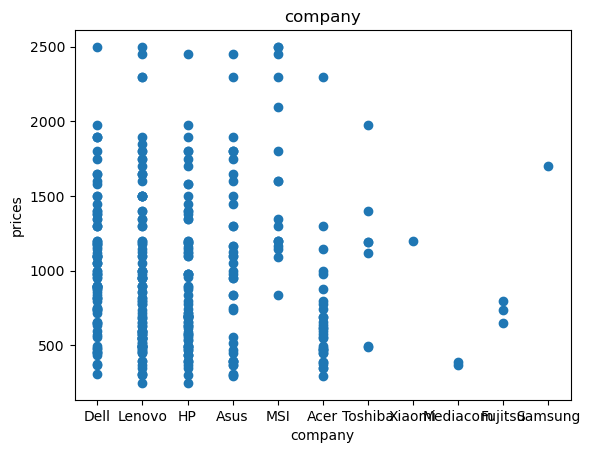

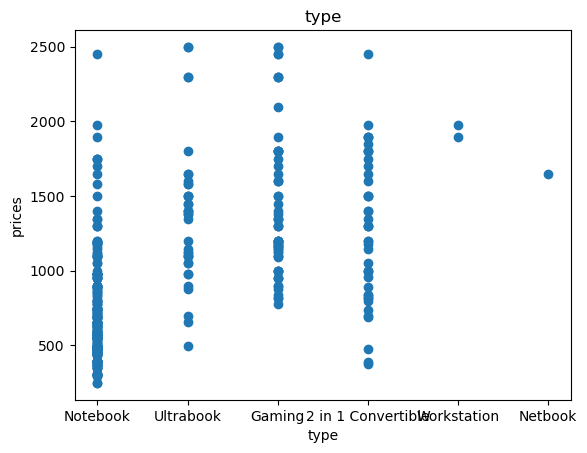

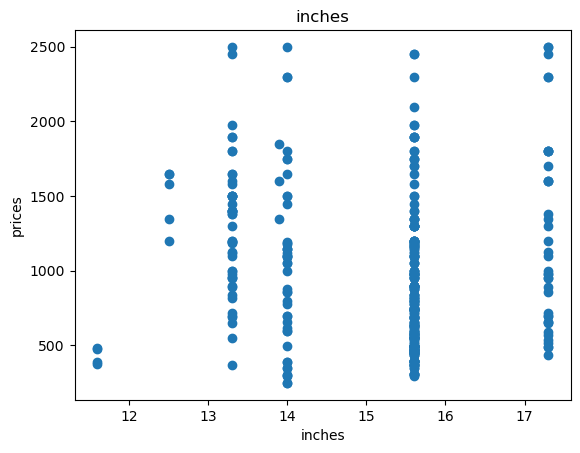

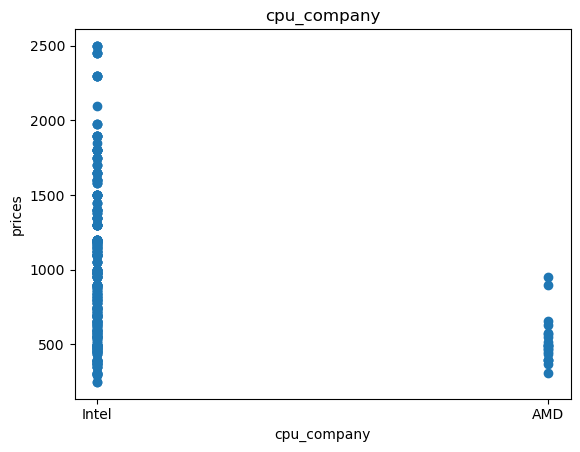

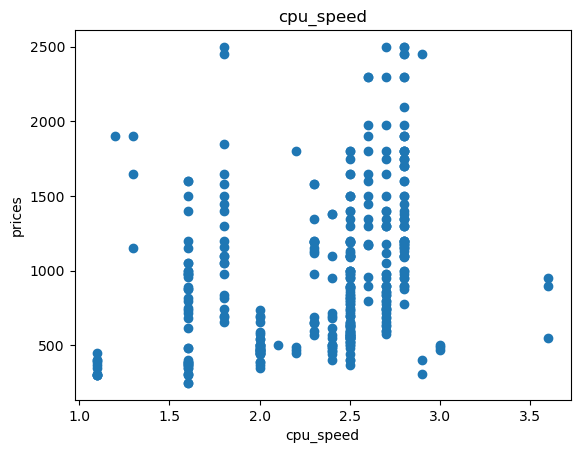

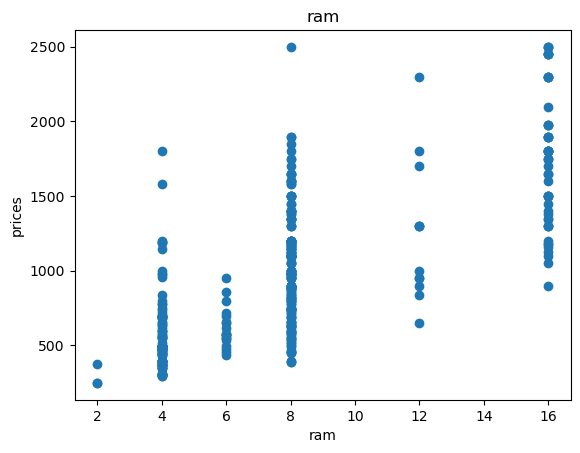

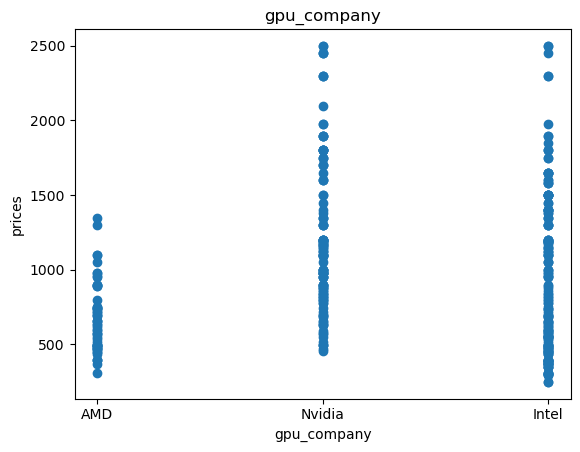

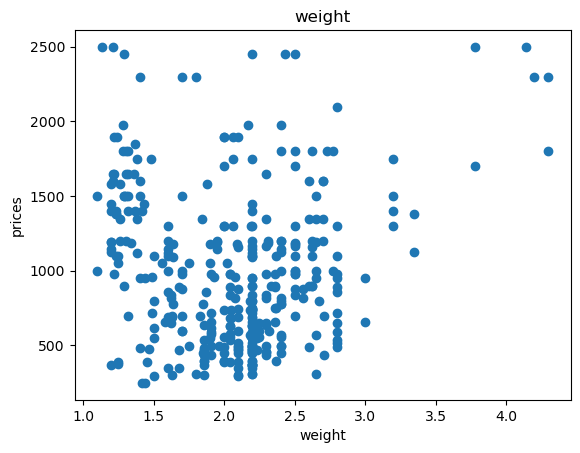

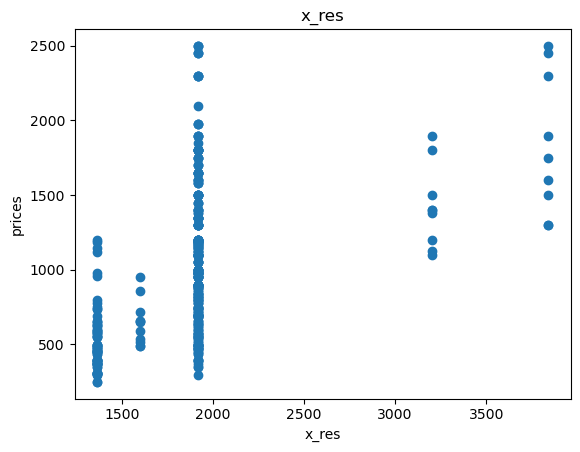

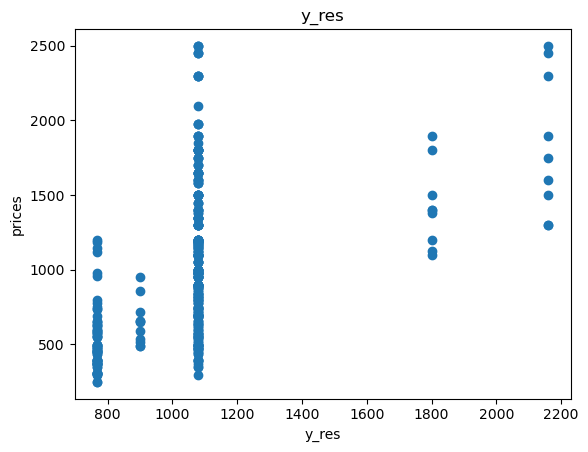

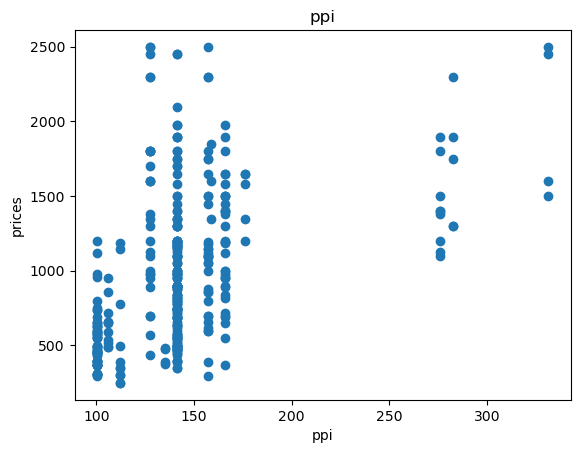

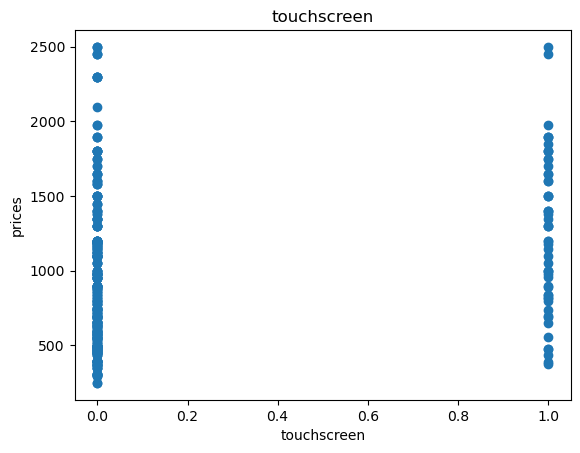

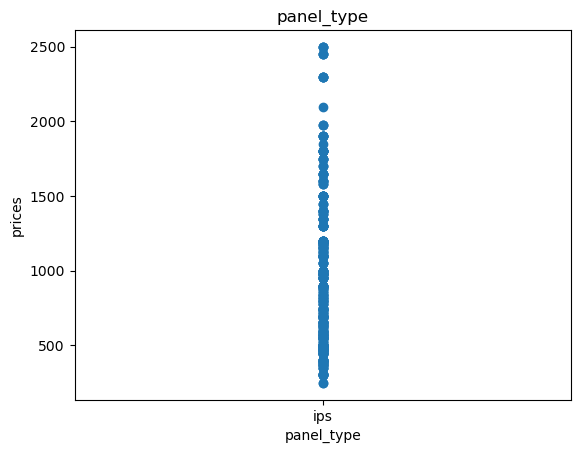

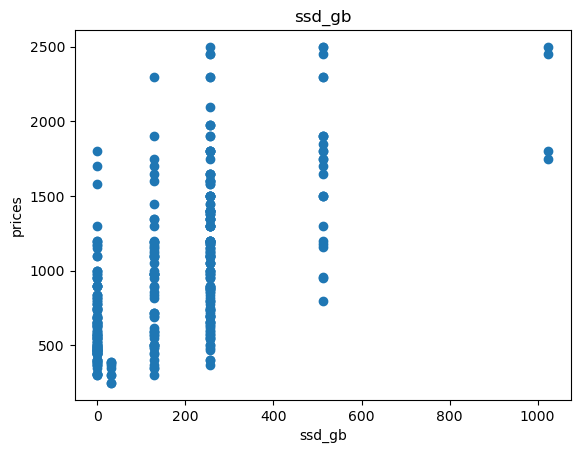

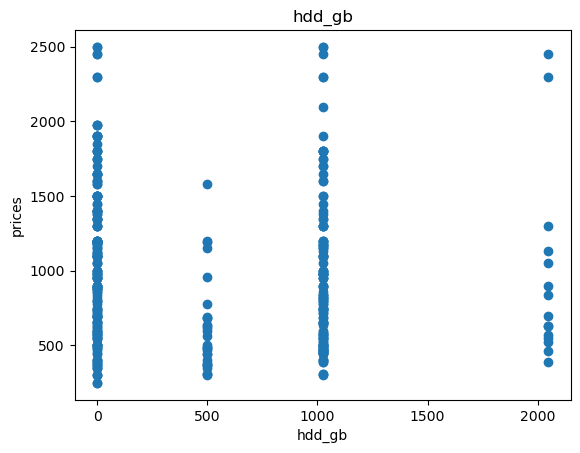

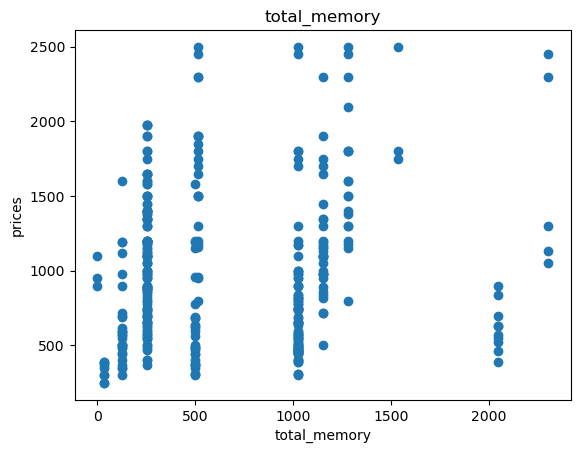

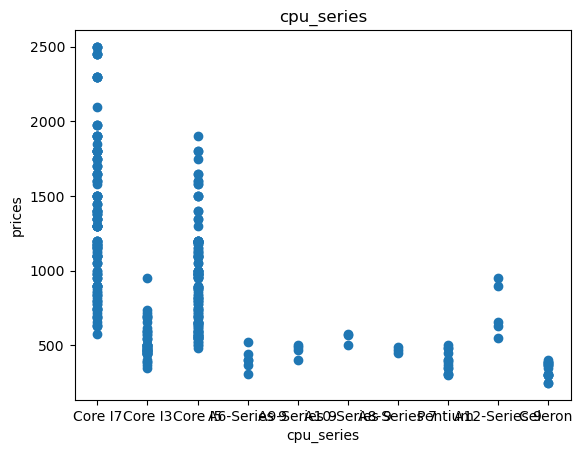

In [884]:
for label in df_plotting.columns[:-1]:
  plt.scatter(df_plotting[label], df_plotting["price"])
  plt.title(label)
  plt.ylabel("prices")
  plt.xlabel(label)
  plt.show()

#### Remove columns that do not have a linear relationship/are weak

In [885]:
# verify with graph
corr_matrix = df.corr(numeric_only=True)
corr_with_price = corr_matrix["price"].sort_values(ascending=False)
print(corr_with_price)

price                      1.000000
ram                        0.724726
ssd_gb                     0.612466
cpu_series_Core I7         0.583714
y_res                      0.483286
x_res                      0.483185
ppi                        0.461967
type_Gaming                0.376373
cpu_speed                  0.317983
gpu_company_Nvidia         0.315024
company_MSI                0.269634
type_Ultrabook             0.254377
touchscreen                0.223003
cpu_company_Intel          0.221109
type_Workstation           0.138308
total_memory               0.107320
company_Samsung            0.073292
type_Netbook               0.068274
company_Dell               0.067124
company_Toshiba            0.038549
company_Asus               0.038265
weight                     0.022572
company_Xiaomi             0.022087
company_Lenovo            -0.027163
company_Fujitsu           -0.045235
cpu_series_Core I5        -0.046108
cpu_series_A12-Series 9   -0.056716
company_HP                -0

In [886]:
df = df.drop([ 'panel_type', 'weight', 'hdd_gb', 'inches'], axis=1)

## Train, valid, test dataset

In [887]:
# randomize data
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

train = df_shuffled.iloc[:int(0.6*len(df_shuffled))]
val   = df_shuffled.iloc[int(0.6*len(df_shuffled)):int(0.8*len(df_shuffled))]
test  = df_shuffled.iloc[int(0.8*len(df_shuffled)):]


In [888]:
# get respective xs and ys
x_train = train.drop(['price'], axis=1)
y_train = train['price']

x_val = val.drop(['price'], axis=1)
y_val = val['price']

x_test = test.drop(['price'], axis=1)
y_test = test['price']

In [889]:
# 1️⃣ Save the column order used for training
feature_cols = list(x_train.columns)

# 2️⃣ Compare each split's order to training
same_val = list(x_train.columns) == list(x_val.columns)
same_test = list(x_train.columns) == list(x_test.columns)

if same_val and same_test:
    print("✅ Column order matches across all splits.")
else:
    print("❌ Column order mismatch detected!")

# 3️⃣ If mismatch, find exactly where it happens
for i, (a, b) in enumerate(zip(x_train.columns, x_test.columns)):
    if a != b:
        print(f"Mismatch at position {i}: Train = {a}, Test = {b}")

# 4️⃣ Optional extra check
print("\nColumn counts:")
print("Train:", len(x_train.columns))
print("Val:  ", len(x_val.columns))
print("Test: ", len(x_test.columns))


✅ Column order matches across all splits.

Column counts:
Train: 35
Val:   35
Test:  35


## Models

### Simple regression with sklearn

In [890]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

LinearRegression()

#### r^2 value

In [891]:
lin_reg.score(x_test, y_test)

0.7606361930865693

#### plotting

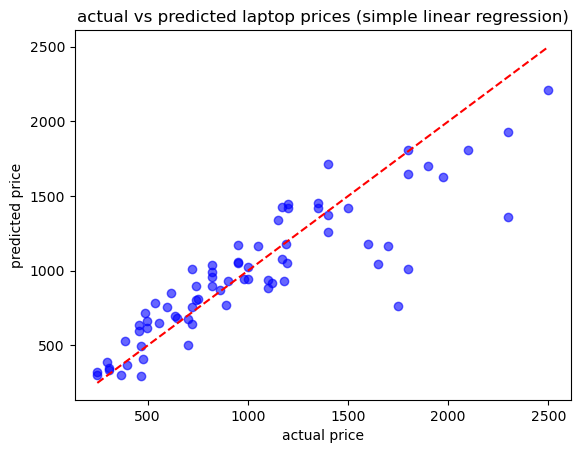

In [892]:
y_pred = lin_reg.predict(x_test)

plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.xlabel("actual price")
plt.ylabel("predicted price")
plt.title("actual vs predicted laptop prices (simple linear regression)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

In [893]:
y_pred_train = lin_reg.predict(x_train)
y_pred_val = lin_reg.predict(x_val)
y_pred_test = lin_reg.predict(x_test)

#### See how good model is 

In [894]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# find Coefficient of Determinations
r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)
r2_test = r2_score(y_test, y_pred_test)

# Mean Absolute Error 
mae = mean_absolute_error(y_test, y_pred_test)

# Mean Squared Error 
mse = mean_squared_error(y_test, y_pred_test)

# Root Mean Squared Error
rmse = np.sqrt(mse)

print(f"R2 (Train): {r2_train:.3f}")
print(f"R2 (Validation): {r2_val:.3f}")
print(f"R2 (Test): {r2_test:.3f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")


R2 (Train): 0.756
R2 (Validation): 0.682
R2 (Test): 0.761
MAE: 181.36
MSE: 68734.37
RMSE: 262.17


### Regression with Neural Network

In [ ]:
# Recreate arrays cleanly and consistently

x_train_array = x_train.to_numpy(dtype="float32")
x_val_array   = x_val.to_numpy(dtype="float32")
x_test_array  = x_test.to_numpy(dtype="float32")

y_train_array = y_train.to_numpy(dtype="float32").reshape(-1, 1)
y_val_array   = y_val.to_numpy(dtype="float32").reshape(-1, 1)
y_test_array  = y_test.to_numpy(dtype="float32").reshape(-1, 1)


In [912]:
x_train.head()

,cpu_speed,ram,x_res,y_res,ppi,touchscreen,ssd_gb,company_Asus,company_Dell,company_Fujitsu,...,gpu_company_Nvidia,cpu_series_A12-Series 9,cpu_series_A6-Series 9,cpu_series_A8-Series 7,cpu_series_A9-Series 9,cpu_series_Celeron,cpu_series_Core I3,cpu_series_Core I5,cpu_series_Core I7,cpu_series_Pentium
0,2.5,8,1920.0,1080.0,141.211998,0,256,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1,2.0,4,1920.0,1080.0,141.211998,0,256,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,2.8,16,1920.0,1080.0,127.335675,0,256,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,2.7,12,1920.0,1080.0,165.632118,1,256,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,1.8,16,1920.0,1080.0,141.211998,0,256,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [913]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(x_train.shape[1],), axis=-1)
all_normalizer.adapt(x_train_array)


c:\Users\Beast\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [914]:
print("Normalizer mean (first 5):", all_normalizer.mean.numpy().flatten()[:5])
print("Normalizer variance (first 5):", all_normalizer.variance.numpy().flatten()[:5])


Normalizer mean (first 5): [   2.339    7.873 1868.945 1051.2    143.787]
Normalizer variance (first 5): [     0.205     13.729 195615.1    61940.164   1629.795]


In [915]:
train_norm = all_normalizer(x_train_array)
val_norm   = all_normalizer(x_val_array)
test_norm  = all_normalizer(x_test_array)

import numpy as np

print("Train mean after normalization:", np.mean(train_norm.numpy()))
print("Val   mean after normalization:", np.mean(val_norm.numpy()))
print("Test  mean after normalization:", np.mean(test_norm.numpy()))

print("\nTrain std after normalization:", np.std(train_norm.numpy()))
print("Val   std after normalization:", np.std(val_norm.numpy()))
print("Test  std after normalization:", np.std(test_norm.numpy()))


Train mean after normalization: 6.1198353e-09
Val   mean after normalization: -0.005892679
Test  mean after normalization: 3974.5676

Train std after normalization: 0.9851843
Val   std after normalization: 0.9709951
Test  std after normalization: 199323.44


In [916]:
np.set_printoptions(suppress=True, precision=3)
print("Feature-wise mean difference between train and test:")
print(np.mean(x_test_array, axis=0) - np.mean(x_train_array, axis=0))

print("\nColumns where means differ drastically:")
for i, c in enumerate(x_train.columns):
    if abs(np.mean(x_test_array[:, i]) - np.mean(x_train_array[:, i])) > 100:
        print(c)


Feature-wise mean difference between train and test:
[  0.022   0.181  57.514  32.368   0.929  -0.006 -20.301   0.035  -0.016
  -0.014  -0.074   0.052   0.045  -0.005   0.014   0.004  -0.005   0.098
  -0.005  -0.028  -0.06   -0.005   0.023  -0.149   0.151  -0.005   0.009
  -0.014  -0.009   0.018   0.026  -0.012   0.019  -0.027]

Columns where means differ drastically:


In [899]:
nn_model = tf.keras.Sequential([
  all_normalizer,
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')


In [900]:
# trian
history = nn_model.fit(
    x_train_array, y_train_array,
    validation_data=(x_val_array, y_val_array),
    epochs=100,
    verbose=1
)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1199193.2500 - val_loss: 1219913.7500
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1197932.7500 - val_loss: 1218688.7500
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1196645.1250 - val_loss: 1217335.3750
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1195123.7500 - val_loss: 1215739.1250
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1193288.1250 - val_loss: 1213829.6250
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1191183.2500 - val_loss: 1211457.6250
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1188455.6250 - val_loss: 1208575.0000
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1185076.6250 - val_loss: 1205086.5000
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1181259.5000 - val_loss: 1200787.7500
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1176378.8750 - val_loss: 1195572.8750
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/ste

In [901]:

def plot_history(history):
  # Plot training & validation loss values
  plt.plot(history.history['loss'], label=' Loss')
  plt.plot(history.history['val_loss'], label='val Loss')

  plt.xlabel('Epoch')
  plt.ylabel('Loss (MSE)')
  plt.legend()
  plt.grid(True)
  plt.show()


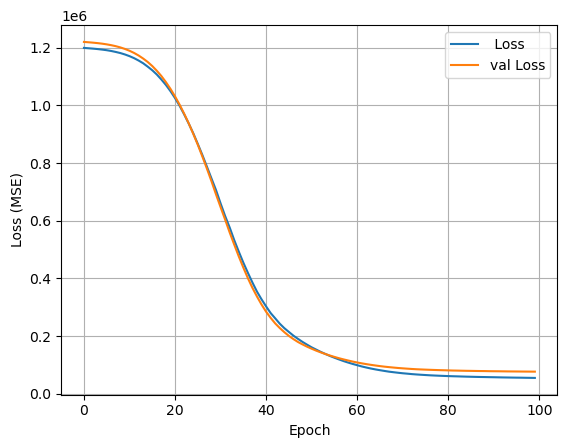

In [902]:
plot_history(history)

In [903]:
# 📊 5️⃣ Evaluate properly (using the same normalization inside the model)
y_pred_train = nn_model.predict(x_train_array).flatten()
y_pred_val   = nn_model.predict(x_val_array).flatten()
y_pred_test  = nn_model.predict(x_test_array).flatten()

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def eval_split(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n📈 {name} Metrics:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.3f}")

eval_split("Train", y_train_array, y_pred_train)
eval_split("Validation", y_val_array, y_pred_val)
eval_split("Test", y_test_array, y_pred_test)




7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

📈 Train Metrics:
MSE: 54748.45
RMSE: 233.98
MAE: 168.96
R²: 0.775

📈 Validation Metrics:
MSE: 76684.44
RMSE: 276.92
MAE: 203.71
R²: 0.727

📈 Test Metrics:
MSE: 1871594410475520.00
RMSE: 43261927.96
MAE: 5029284.50
R²: -6517728256.000


In [904]:
print("y_train:", 
      f"min={y_train.min():.2f}, max={y_train.max():.2f}, mean={y_train.mean():.2f}, std={y_train.std():.2f}")
print("y_test:", 
      f"min={y_test.min():.2f}, max={y_test.max():.2f}, mean={y_test.mean():.2f}, std={y_test.std():.2f}")



y_train: min=299.00, max=2499.00, mean=978.21, std=494.16
y_test: min=249.00, max=2499.00, mean=1012.14, std=539.53


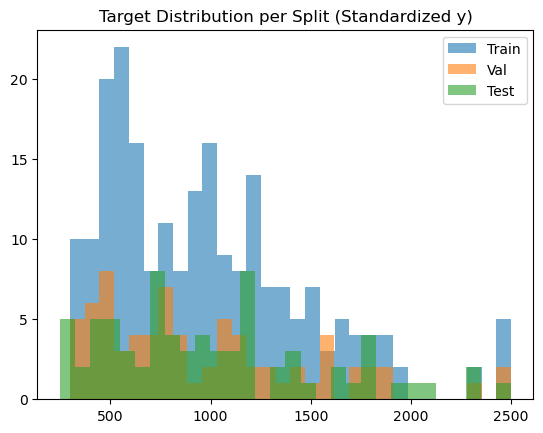

In [905]:
import matplotlib.pyplot as plt

plt.hist(y_train, bins=30, alpha=0.6, label='Train')
plt.hist(y_val, bins=30, alpha=0.6, label='Val')
plt.hist(y_test, bins=30, alpha=0.6, label='Test')
plt.legend()
plt.title("Target Distribution per Split (Standardized y)")
plt.show()


In [906]:
import pandas as pd
from scipy.stats import ks_2samp

def compare_distributions(train_df, test_df):
    diffs = []
    for col in train_df.columns:
        stat, p = ks_2samp(train_df[col], test_df[col])
        diffs.append({"feature": col, "KS_stat": stat, "p_value": p})
    return pd.DataFrame(diffs).sort_values("KS_stat", ascending=False)

shift_df = compare_distributions(pd.DataFrame(x_train_array, columns=x_train.columns),
                                 pd.DataFrame(x_test_array, columns=x_test.columns))

display(shift_df.head(10))


,feature,KS_stat,p_value
7,total_memory,0.181327,0.044857
25,gpu_company_Nvidia,0.150614,0.143966
24,gpu_company_Intel,0.149140,0.150722
18,type_Gaming,0.097789,0.619728
6,ssd_gb,0.085504,0.771360
11,company_HP,0.074201,0.893174
4,ppi,0.065602,0.954743
21,type_Ultrabook,0.059582,0.981138
0,cpu_speed,0.057125,0.987286
12,company_Lenovo,0.051720,0.996101
